In [1]:
import nilearn
import pandas as pd
import numpy as np
import os
import os.path

In [2]:
# Read CSV
df = pd.DataFrame(columns=['id', 'folder', 'is_asd'])
csv = pd.read_csv('5320_ABIDE_Phenotypics_20201201.csv')[1:]
csv.SubID = csv.SubID.apply(int)

# Read all files, and add their path to the data frame & link it with the CSV to know whether they have ASD
universities = os.listdir('./data')
for univ in universities:
  ids = os.listdir(os.path.join('./data/', univ))
  
  for id_ in ids:
    folder = os.path.join('./data', univ, id_, 'session_1/anat_1/')

    try:
        file_msp = os.path.join(folder, [f for f in os.listdir(folder) if f.endswith('msp.nii')][0])
    except IndexError:
        file_msp = None
    
    try:
        file_cc = os.path.join(folder, [f for f in os.listdir(folder) if f.endswith('cc.nii')][0])
    except IndexError:
        file_cc = None

    file_gz = os.path.join(folder, [f for f in os.listdir(folder) if f.endswith('gz')][0])

    is_asd = csv[csv.SubID == int(id_)].DxGroup.iloc[0] == '1'
    df = pd.concat([df, pd.DataFrame([{'id': id, 'folder': folder, 'msp': file_msp, 'cc': file_cc, 'gz': file_gz, 'is_asd': is_asd}])], axis=0)

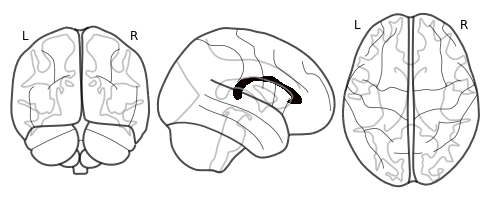

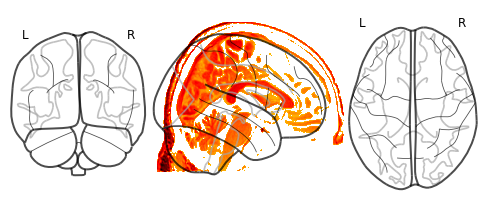

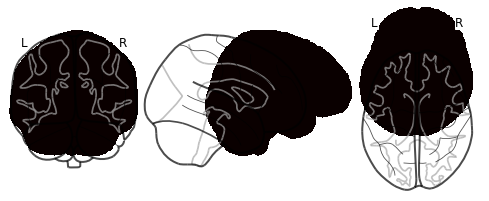

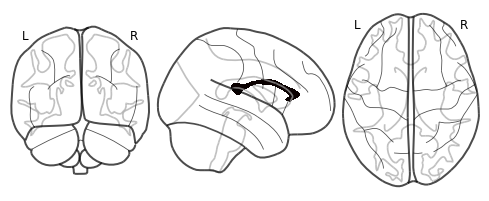

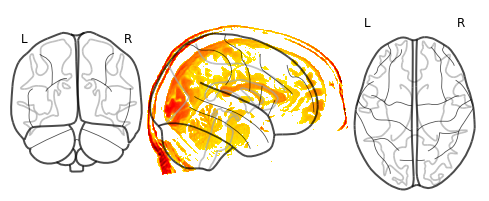

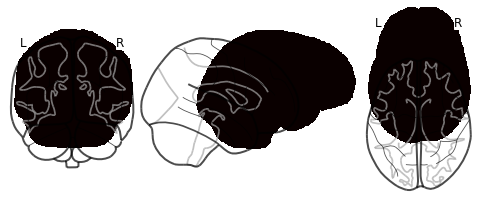

In [3]:
from nilearn import plotting

row = df[df.is_asd == True].iloc[0]
plotting.plot_glass_brain(row['cc'])
plotting.plot_glass_brain(row['msp'])
plotting.plot_glass_brain(row['gz'])

row = df[df.is_asd == False].iloc[0]
plotting.plot_glass_brain(row['cc'])
plotting.plot_glass_brain(row['msp'])
plotting.plot_glass_brain(row['gz'])

In [4]:
import nilearn.image as niimage 

In [5]:
img = niimage.load_img(row['gz'])
data = img.get_data()
print(data.shape)

(176, 256, 256)


In [6]:
import torch
from torch import nn
cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if cuda else 'cpu')
cuda, device

(True, device(type='cuda', index=0))

In [7]:
import time
from scipy.ndimage import zoom
from itertools import chain

def flatten(iterables):
   return list(chain(*iterables))

class Net(nn.Module):
    def __init__(self, channels=[8, 16], kernels=[5, 5], neurons=[10]):
        super().__init__()

        if len(channels) != len(kernels):
            raise ValueError('Length of channels is different of length of kernels')

        conv3d_layers = flatten([
            [nn.Conv3d(1 if i == 0 else channels[i - 1], channels[i], kernels[i]), nn.MaxPool3d(2)] for i in range(len(channels))
        ])

        pre_layers = [
            *conv3d_layers,
            nn.Flatten(),
        ]

        a = nn.Sequential(*pre_layers)
        x = torch.randn(1, 1, 128, 128, 128)
        l = a(x).shape[1]

        linear_layers = flatten([
            [nn.Linear(l if i == 0 else neurons[i - 1], neurons[i]), nn.Softmax(), nn.LayerNorm(neurons[i])] for i in range(len(neurons))
        ])

        self.fc = nn.Sequential(
            *pre_layers,
            *linear_layers,
            nn.Linear(neurons[-1], 2),
            nn.Softmax(),
        )
    
    def forward(self, X):
        output = self.fc(X)
        return output
    
    def load_model(self, model_path):
        self.load_state_dict(torch.load(model_path))
        self.eval()
        return self

class Net2(nn.Module):
    def __init__(self):
        super().__init__()

        pre_layers = [
            nn.Conv3d(1, 8, 3),
            nn.ReLU(),
            nn.Conv3d(8, 8, 3),
            nn.ReLU(),
            nn.AvgPool3d(2),
            nn.Conv3d(8, 16, 3),
            nn.ReLU(),
            nn.Conv3d(16, 16, 3),
            nn.ReLU(),
            nn.AvgPool3d(2),
            nn.Conv3d(16, 32, 3),
            nn.ReLU(),
            nn.Conv3d(32, 32, 3),
            nn.ReLU(),
            nn.Conv3d(32, 32, 3),
            nn.ReLU(),
            nn.AvgPool3d(2),
            nn.Conv3d(32, 64, 3),
            nn.ReLU(),
            nn.Conv3d(64, 64, 3),
            nn.ReLU(),
            nn.Conv3d(64, 64, 3),
            nn.ReLU(),
            nn.AvgPool3d(2),
            nn.Flatten(),
        ]

        a = nn.Sequential(*pre_layers)
        x = torch.randn(1, 1, 128, 128, 128)
        l = a(x).shape[1]

        self.fc = nn.Sequential(
            *pre_layers,
            nn.Linear(l, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.7),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2),
            nn.Softmax(),
        )
    
    def forward(self, X):
        output = self.fc(X)
        return output
    
    def load_model(self, model_path):
        self.load_state_dict(torch.load(model_path))
        self.eval()
        return self

def train(loader, model, criterion, optimizer, metric, num_epochs=10):
    """
    Train function
    """
    print('Starting training.')
    start_time = time.time()
    losses = []
    metrics = []

    for epoch in range(num_epochs):
        losses_ = []
        metrics_ = []
        metric.reset()

        for i, data in enumerate(loader):
            # Data loading
            x, y = data[0], data[1]
            if cuda:
                x = x.cuda()
                y = y.cuda()

            x.requires_grad = True
            output = model(x)

            # Backpropagation
            optimizer.zero_grad()

            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            
            # Display & metrics
            losses_.append(float(loss))
            metrics_.append(metric(output, y))

            print('\rEpoch {:>4} of {}, Train Loss: {:5.2f}, Elapsed time: {:>4}s, Accuracy: {:6.2%}, Current: {:>4}/{:>4}'.format(epoch+1, num_epochs, np.mean(losses_), round(time.time()-start_time), metric.value(), i, len(loader)),flush=True, end="")

        losses.append(losses_)
        metrics.append(metrics_)
        elapsed_time = time.time() - start_time
        estimated_time = elapsed_time / (epoch+1) * num_epochs - elapsed_time
        print('\rEpoch {:>4} of {}, Train Loss: {:5.2f}, Accuracy: {:6.2%}, Elapsed time: {:>4}s, Estimated remaining time: {}min'.format(epoch+1, num_epochs, np.mean(losses[-1]), np.mean(metrics[-1]), round(elapsed_time), estimated_time // 60),flush=True)
    return losses, metrics

In [8]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

def resize(img):
    return zoom(img, (128 / img.shape[0], 128 / img.shape[1], 128 / img.shape[2]))

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        img = niimage.load_img(self.X.iloc[i])
        data = img.get_data().astype(np.float32)
        data = resize(data)
        data = data.reshape((1, *data.shape))

        label = self.y.iloc[i]
        label = torch.tensor(int(label))

        return data, label

In [9]:
class AccuracyMetric:
    def __init__(self, threshold):
        self.correct = 0
        self.total = 0
        self.threshold = threshold
    
    def __call__(self, output, labels):
        result = []
        
        for pred, label in zip(output, labels):
            result.append(
              bool(pred[label] > pred[1 - label])
            )

        self.correct += sum(result)
        self.total += len(result)
        return self.value()
    
    def reset(self):
        self.correct = 0
        self.total = 0
    
    def value(self):
        return float(self.correct) / self.total

In [1]:
from torch import optim

params = {
    'batch_size': 2,
    'shuffle': True,
    'num_workers': 0,
}

dataset = CustomDataset(df['gz'], df['is_asd'])

loader = DataLoader(dataset, **params)

# model = Net(channels=[4, 8, 16, 32], kernels=[5, 5, 5, 5], neurons=[1000, 1000, 100, 10])
model = Net2()

if cuda:
    model = model.cuda()

optimizer = optim.Adam(model.parameters(), lr=27e-4)
criterion = nn.CrossEntropyLoss()
metric = AccuracyMetric(0.5)

loss, acc = train(loader, model, criterion, optimizer, metric, num_epochs=20)
torch.save(model.state_dict, 'model.torch')

NameError: name 'CustomDataset' is not defined

In [58]:
metric.reset()
for data in loader:
    x, y = data
    if cuda:
        x = x.cuda()
        y = y.cuda()
    output = model(x)
    metric(output, y)

    print([float(i[0]) for i in output])
metric.value()

[1.0, 1.0]
[1.0, 1.0]
[1.0, 1.0]
[1.0, 1.0]
[1.0, 1.0]
[1.0, 1.0]
[1.0, 1.0]
[1.0, 1.0]
[1.0, 1.0]


KeyboardInterrupt: 

In [49]:
print('{:6%}'.format(metric.value()))

48.185118%


In [47]:
print('{:6%}'.format(df.is_asd.sum() / len(df)))

48.185118%


In [57]:
[float(i[0]) for i in output]

[1.0, 1.0]

In [46]:
y

tensor([[0.],
        [0.]], device='cuda:0')